In [1]:
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import random
import time
import math
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

num_train=260864
num_test=261477

In [2]:
user_info={}
f=open('data_format1/user_info_format1.csv')
for line in f:
    l=line.strip()
    if l=='user_id,age_range,gender':
        continue
    [user,age_range,gender]=l.split(',')
    if age_range=='':
        age_range='3'
    if gender=='':
        gender='0'
    user_info[user]=(int(age_range),int(gender))

In [3]:
class predictor(object):
    def __init__(self, mode):
        self.mode=mode
        if mode=='logistic regression':
            self.clf=LogisticRegression(C=1e-3,class_weight='balanced',max_iter=10000,tol=1e-8)
        elif mode=='decision tree':
            self.clf=DecisionTreeClassifier(criterion='entropy',class_weight='balanced',min_samples_leaf=1000, max_leaf_nodes=5000)
    def train(self):
        self.clf.fit(X_train,y_train)
    def predict(self,test_data):
        return self.clf.predict_proba(test_data)[:,1]

(260864, 17)
test time # 1  ,AUC = 0.621537396667
average_AUC = 0.621537396667


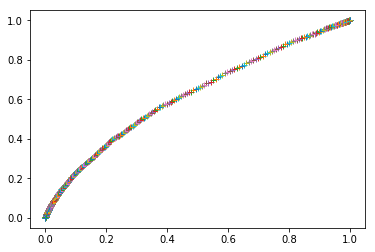

In [4]:
average_AUC=0
test_time=1

for tt in range(test_time):

    data_X=np.load('data/x_userinfo_ratio.npy') # 0,1,2,3,4,5,6,7
    data_X_bias=np.load('data/x_bias.npy') # 8,9
    data_X_bi=np.load('data/x_userinfo_branditem.npy') # 10,11
    data_X_monthly=np.load('data/x_monthly.npy') # 12,13,14,15
    data_y=np.load('data/y.npy') # 16
    data=np.column_stack((data_X,data_X_bias))
    data=np.column_stack((data,data_X_bi))
    data=np.column_stack((data,data_X_monthly))
    data=np.column_stack((data,data_y))
    print(data.shape)
    data=list(data)
    new_data=[]
    for datum in data:
        l=list(datum)
#         new_data.append([l[1],l[2],l[3],l[3]/l[7],l[4],l[4]/l[7],l[5],l[5]/l[7],l[6],l[6]/l[7],l[7],int(l[8])])
        new_data.append([l[1]==1,l[1]==2,l[1]==3,l[1]==4,l[1]==5,l[1]==6,l[1]>=7,l[2],
#                          l[3],l[3]/l[7],l[4],l[4]/l[7],l[5],l[5]/l[7],l[6],l[6]/l[7],l[7],
                         l[3],l[4],l[5],l[6],l[7],
                         l[8],l[9],l[10],l[11],l[12],l[13],l[14],l[15],
                         int(l[16])])
    random.shuffle(new_data)
    new_data=np.array(new_data)
#     np.save('data/new_data_train.npy',new_data)
    data_X=new_data[:,:-1]
    data_y=new_data[:,-1]
    data_y=data_y.astype(int)
#     print(data_X.shape)
#     print(data_y.shape)

    ratio=0.8
    X_train=data_X[:int(num_train*ratio),:]
    y_train=data_y[:int(num_train*ratio)]
    X_val=data_X[int(num_train*ratio):,:]
    y_val=data_y[int(num_train*ratio):]
#     print(X_train.shape)
#     print(y_train.shape)
#     print(X_val.shape)
#     print(y_val.shape)
#     print(np.sum(y_train))
#     print(np.sum(y_val))

    lr=predictor('logistic regression')
    lr.train()
    bounds=np.linspace(0.0,1.0,1001)
    perform_his=[]
    
    prob=lr.predict(X_val)

    for bound in bounds:
        pre=prob>bound
        true_pos=np.sum(np.logical_and(pre==1,y_val==1))
        true_neg=np.sum(np.logical_and(pre==0,y_val==0))
        false_pos=np.sum(np.logical_and(pre==1,y_val==0))
        false_neg=np.sum(np.logical_and(pre==0,y_val==1))
        TPR=true_pos/(true_pos+false_neg)
        FPR=false_pos/(false_pos+true_neg)
        perform_his.append((FPR,TPR))
        if tt==test_time-1:
            plt.plot(FPR,TPR,'+')
    perform_his_s= sorted(perform_his, key=lambda d:d[0])

    AUC=0
    for i in range(1,len(perform_his_s)):
        pre_p=perform_his_s[i-1]
        cur_p=perform_his_s[i]
        AUC+=(cur_p[1]+pre_p[1])*(cur_p[0]-pre_p[0])/2

    print('test time #',(tt+1),' ,AUC =',AUC)

    # pre=lr.predict_proba(X_val)[:,1]>best_bound
    # true_pos=np.sum(np.logical_and(pre==1,y_val==1))
    # true_neg=np.sum(np.logical_and(pre==0,y_val==0))
    # false_pos=np.sum(np.logical_and(pre==1,y_val==0))
    # false_neg=np.sum(np.logical_and(pre==0,y_val==1))
    # TPR=true_pos/np.sum(pre==1)
    # TNR=true_neg/np.sum(pre==0)
    # BER=1-(TPR+TNR)/2
    # precision=true_pos/(true_pos+false_pos)
    # recall=true_pos/(true_pos+false_neg)
    # F1=2*precision*recall/(precision+recall)
    # print('true_pos =',true_pos)
    # print('true_neg =',true_neg)
    # print('false_pos =',false_pos)
    # print('false_neg =',false_neg)
    # print('BER =',BER)
    # print('precision =',precision)
    # print('recall =',recall)
    # print('F1 score =',F1)
    
    average_AUC+=AUC
    
print('average_AUC =',average_AUC/test_time)
plt.show()

In [5]:
X_test=np.load('data/x_userinfo_ratio_test.npy')
X_test_bias=np.load('data/x_bias_test.npy')
X_test_bi=np.load('data/x_userinfo_branditem_test.npy') # 10,11
X_test_monthly=np.load('data/x_monthly_test.npy') # 12,13,14,15
data_test=np.column_stack((X_test,X_test_bias))
data_test=np.column_stack((data_test,X_test_bi))
data_test=np.column_stack((data_test,X_test_monthly))
print(data_test.shape)
data_test=list(data_test)
new_data_test=[]
for datum in data_test:
    l=list(datum)
#     new_data_test.append([l[1],l[2],l[3],l[3]/l[7],l[4],l[4]/l[7],l[5],l[5]/l[7],l[6],l[6]/l[7],l[7]])
    new_data_test.append([l[1]==1,l[1]==2,l[1]==3,l[1]==4,l[1]==5,l[1]==6,l[1]>=7,l[2],
#                          l[3],l[3]/l[7],l[4],l[4]/l[7],l[5],l[5]/l[7],l[6],l[6]/l[7],l[7],
                         l[3],l[4],l[5],l[6],l[7],
                         l[8],l[9],l[10],l[11],l[12],l[13],l[14],l[15]])
X_test=np.array(new_data_test)
np.save('data/new_data_test.npy',X_test)
pre=lr.predict(X_test)
print(pre)

(261477, 16)
[ 0.5280825   0.62296275  0.45686772 ...,  0.618551    0.44975201
  0.44680215]


In [6]:
f_out=open('prediction.csv','w')
f_out.write('user_id,merchant_id,prob\n')
f_test=open('data_format1/test_format1.csv')
i=0
for line in f_test:
    l=line.strip()
    if l=='user_id,merchant_id,prob':
        continue
    [user,seller,_]=l.split(',')
    f_out.write(user+','+seller+','+str(pre[i])+'\n')
    i+=1
f_out.close()

In [7]:
# print(X_test)
# print(pre)